# Requisitos

In [1]:
# !pip -q install torch torchvision torchaudio matplotlib tqdm pillow --progress-bar off
import torch, torchvision, matplotlib.pyplot as plt, numpy as np, random, os, itertools
from torchvision import transforms as T
from torch import nn
from pathlib import Path
from tqdm.auto import tqdm
print("Torch", torch.__version__, "CUDA available ->", torch.cuda.is_available())

Torch 2.9.1+cu128 CUDA available -> True


/home/s.lopezmedina/Maestria/4_computer_vision/codigo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Descomprimir dataset

In [2]:
zip_path = Path("celeba_small.zip")
assert zip_path.exists(), "Sube primero celeba_small.zip al entorno Colab"
!unzip -q -n celeba_small.zip -d .
DATA_DIR = Path("img_align_celeba")
print("Total imágenes:", len(list(DATA_DIR.glob('*.jpg'))))

Total imágenes: 50079


# Transformaciones y Dataloader

In [3]:
IMG_SIZE   = 64
BATCH_SIZE = 128

transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),                  # [0,1]
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # [-1,1]
])

dataset = torchvision.datasets.ImageFolder(
    root = DATA_DIR.parent,
    transform = transform
) if False else None  # placeholder

In [4]:
#@title Clase Dataset
class FlatFolderDataset(torch.utils.data.Dataset):
    """Devuelve tensores normalizados a [-1,1] 64×64×3."""
    def __init__(self, root: str | Path, transform=None):
        self.paths = sorted(Path(root).glob('*.jpg'))
        assert self.paths, f"No se encontraron imágenes en {root}"
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        from PIL import Image
        img = Image.open(self.paths[idx]).convert('RGB')  # H,W,RGB
        if self.transform:
            img = self.transform(img)
        return img

train_ds = FlatFolderDataset(DATA_DIR, transform)
loader   = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,
                                      shuffle=True, num_workers=2, pin_memory=True)
print(next(iter(loader)).shape)  # (B,3,64,64)

torch.Size([128, 3, 64, 64])


# Arquitectura

In [5]:
#@title Hiperparámetros
Z_DIM       = 100   # tamaño del espacio latente
FEATURE_G   = 64    # canales iniciales generador
FEATURE_D   = 64    # canales iniciales discriminador
LR          = 2e-4
BETA1       = 0.5   # según DCGAN paper
EPOCHS      = 50
G_UPDATES   = 2     # Numero de actualizaciones de G por iteracion
DEVICE      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
#@title Generador (G)
class Generator(nn.Module):
    def __init__(self, z_dim, g_chan):
        super().__init__()
        self.net = nn.Sequential(
            # input Z → (g_chan*8)×4×4
            nn.ConvTranspose2d(z_dim, g_chan*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(g_chan*8),
            nn.ReLU(True),
            # (g*8)×4×4 → (g*4)×8×8
            nn.ConvTranspose2d(g_chan*8, g_chan*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_chan*4),
            nn.ReLU(True),
            # → (g*2)×16×16
            nn.ConvTranspose2d(g_chan*4, g_chan*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_chan*2),
            nn.ReLU(True),
            # → (g)×32×32
            nn.ConvTranspose2d(g_chan*2, g_chan, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_chan),
            nn.ReLU(True),
            # → 3×64×64
            nn.ConvTranspose2d(g_chan, 3, 4, 2, 1, bias=False),
            nn.Tanh() # Por la normalziación [-1, 1]
            # nn.Sigmoid() # Si normalziación [0, 1]
        )
    def forward(self, z):
        return self.net(z)

In [7]:
#@title Discriminador (D)
class Discriminator(nn.Module):
    def __init__(self, d_chan):
        super().__init__()
        self.net = nn.Sequential(
            # 3×64×64 → (d)×32×32
            nn.Conv2d(3, d_chan, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # → (d*2)×16×16
            nn.Conv2d(d_chan, d_chan*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d_chan*2),
            nn.LeakyReLU(0.2, inplace=True),
            # → (d*4)×8×8
            nn.Conv2d(d_chan*2, d_chan*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d_chan*4),
            nn.LeakyReLU(0.2, inplace=True),
            # → (d*8)×4×4
            nn.Conv2d(d_chan*4, d_chan*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d_chan*8),
            nn.LeakyReLU(0.2, inplace=True),
            # → 1×1×1 (scalar)
            nn.Conv2d(d_chan*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).view(-1)

In [8]:
#@title Inicialización DCGAN
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

gen = Generator(Z_DIM, FEATURE_G).to(DEVICE)
disc = Discriminator(FEATURE_D).to(DEVICE)

gen.apply(weights_init)
disc.apply(weights_init)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

# Entrenamiento

In [9]:
#@title Losses & optimizers
criterion = nn.BCELoss()
opt_G = torch.optim.Adam(gen.parameters(),  lr=LR, betas=(BETA1, 0.999))
opt_D = torch.optim.Adam(disc.parameters(), lr=LR/2, betas=(BETA1, 0.999))

fixed_z = torch.randn(64, Z_DIM, 1, 1, device=DEVICE)

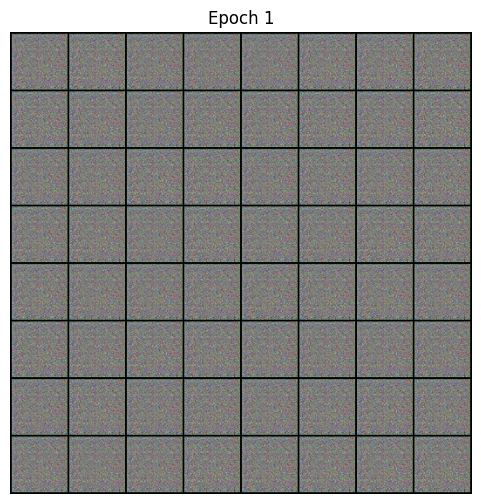

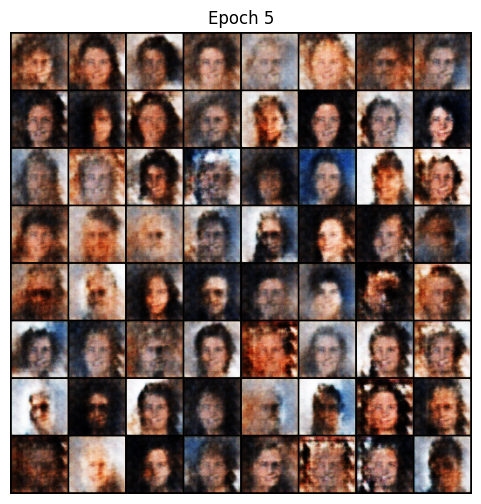

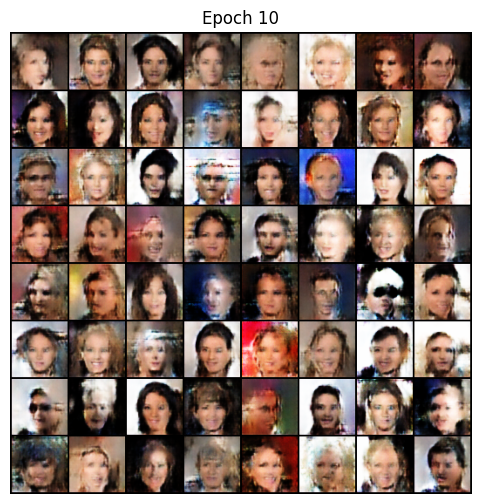

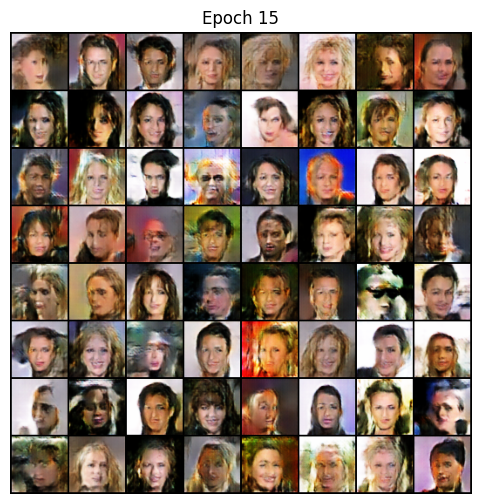

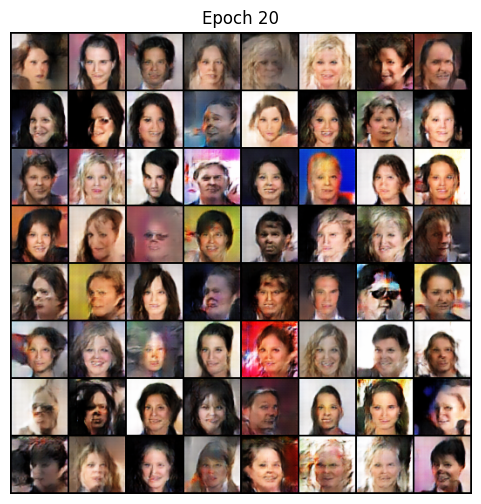

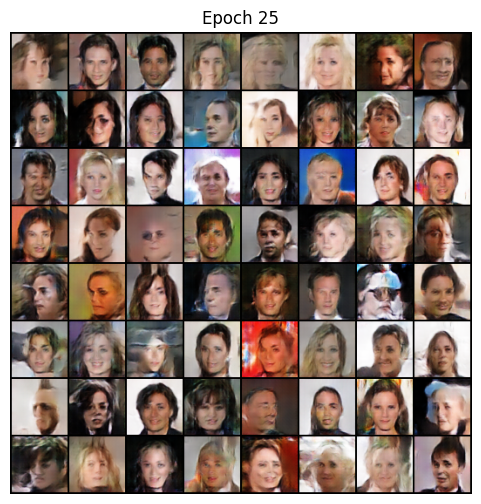

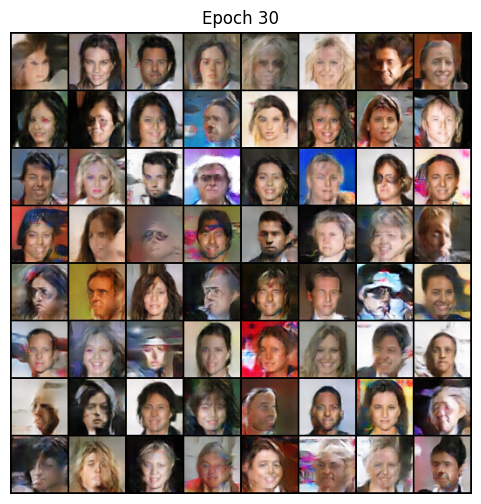

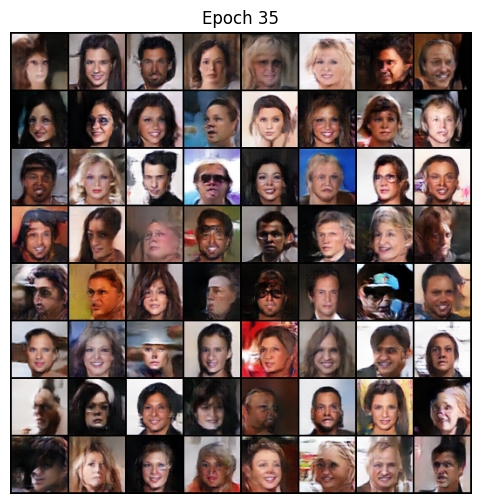

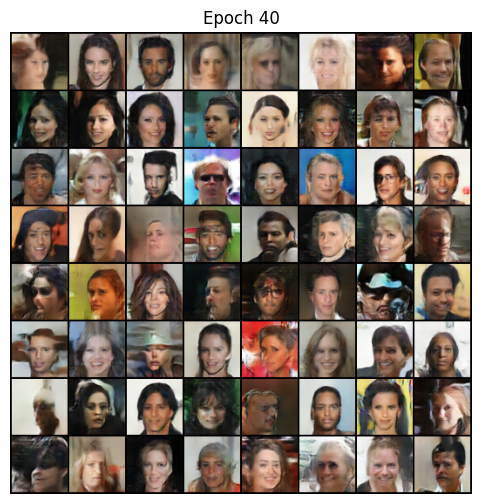

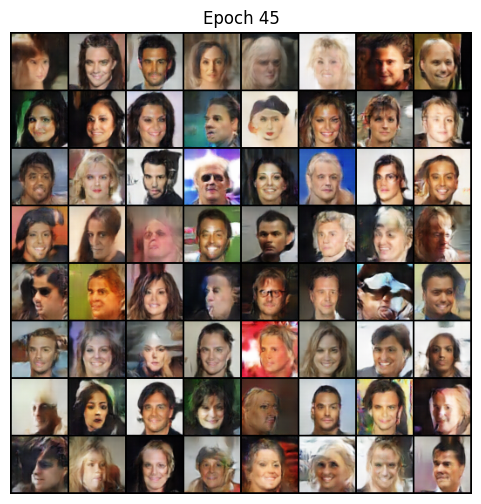

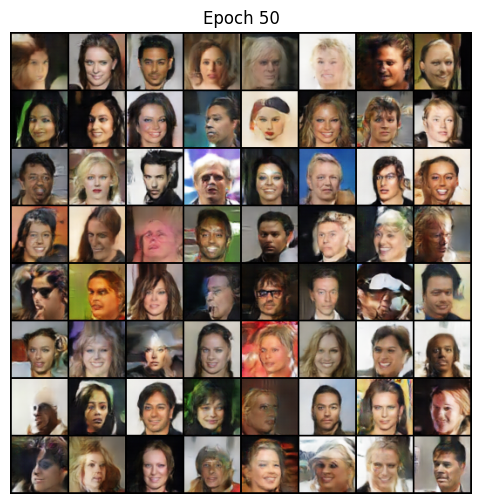

In [10]:
#@title Entrenamiento principal
gen.train(); disc.train()
G_losses, D_losses = [], []

for epoch in range(1, EPOCHS+1):
    pbar = tqdm(loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
    for real in pbar:
        real = real.to(DEVICE)  # (128, 3, 64, 64) imágenes reales
        B = real.size(0)        # B = 128

        ### Entrenar Discriminador ###
        noise = torch.randn(B, Z_DIM, 1, 1, device=DEVICE) # Creando 128 ruidos (z)
        fake  = gen(noise).detach()  # 128 imágenes fake (128,3,64,64) # no grad hacia G

        loss_D_real = criterion(disc(real), torch.ones(B, device=DEVICE))
        loss_D_fake = criterion(disc(fake), torch.zeros(B, device=DEVICE))
        loss_D = (loss_D_real + loss_D_fake) / 2

        opt_D.zero_grad(); loss_D.backward(); opt_D.step()

        ### Entrenar Generador (G_updates) ###
        for _ in range(G_UPDATES):
            noise = torch.randn(B, Z_DIM, 1, 1, device=DEVICE)
            fake  = gen(noise)
            loss_G = criterion(disc(fake), torch.ones(B, device=DEVICE))

            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()

        pbar.set_postfix({"Loss_D": f"{loss_D.item():.3f}", "Loss_G": f"{loss_G.item():.3f}"})

    G_losses.append(loss_G.item()); D_losses.append(loss_D.item())

    # Visualizar progreso cada 5 epochs
    if epoch % 5 == 0 or epoch == 1:
        gen.eval()
        with torch.no_grad():
            sample = gen(fixed_z).cpu()*0.5+0.5  # des-normalizar [0,1]
        gen.train()
        grid = torchvision.utils.make_grid(sample, nrow=8)
        plt.figure(figsize=(6,6)); plt.axis('off'); plt.imshow(grid.permute(1,2,0));
        plt.title(f"Epoch {epoch}"); plt.show()

# Gráficas de entrenamiento y guardado de modeos

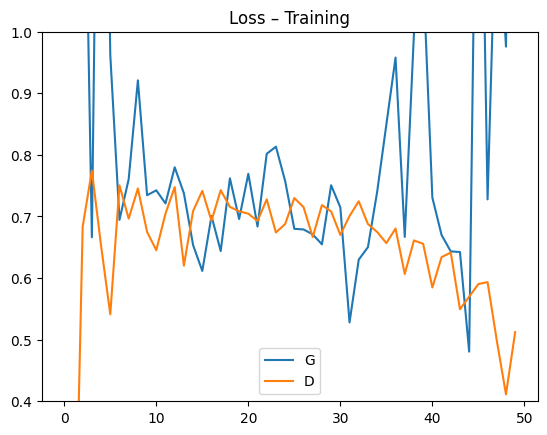

In [11]:
#@title Curvas de pérdida
plt.figure();
plt.plot(G_losses, label='G');
plt.plot(D_losses, label='D');
plt.ylim(0.4, 1.)
plt.legend(); plt.title('Loss – Training'); plt.show()


In [12]:
#@title Guardar generador final (pth)
MODEL_DIR = Path('models'); MODEL_DIR.mkdir(exist_ok=True)
PATH_G = MODEL_DIR/'dcgan_gen_celebA.pth'
PATH_D = MODEL_DIR/'dcgan_disc_celebA.pth'

torch.save(gen.state_dict(), PATH_G)
torch.save(disc.state_dict(), PATH_D)
print('Modelos guardados en', MODEL_DIR.absolute())

Modelos guardados en /home/s.lopezmedina/Maestria/4_computer_vision/codigo/7_gans_celeba/models


# Inferencia

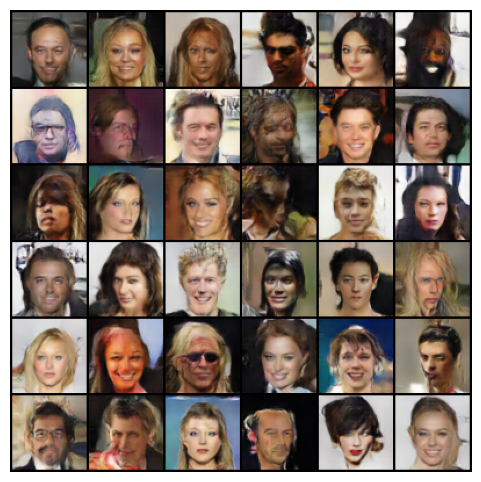

In [13]:
num = 36
z   = torch.randn(num, Z_DIM, 1, 1, device=DEVICE)
with torch.no_grad():
    samples = gen(z).cpu()*0.5+0.5

grid = torchvision.utils.make_grid(samples, nrow=6)
plt.figure(figsize=(6,6)); plt.axis('off');
plt.imshow(grid.permute(1,2,0));
plt.show()

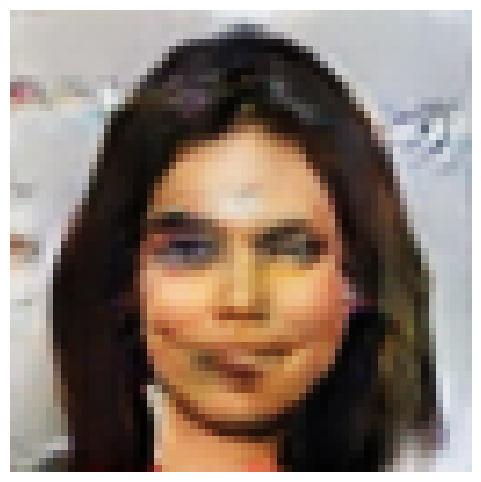

In [14]:
num = 1
z1   = torch.randn(num, Z_DIM, 1, 1, device=DEVICE)
with torch.no_grad():
    samples = gen(z1).cpu()*0.5+0.5

grid = torchvision.utils.make_grid(samples, nrow=6)
plt.figure(figsize=(6,6)); plt.axis('off');
plt.imshow(grid.permute(1,2,0));
plt.show()

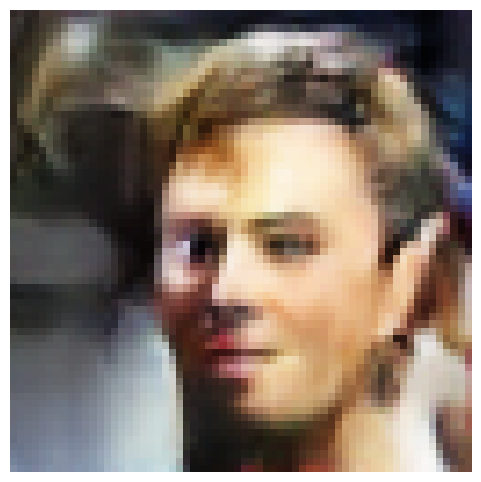

In [15]:
num = 1
z2   = torch.randn(num, Z_DIM, 1, 1, device=DEVICE)
with torch.no_grad():
    samples = gen(z2).cpu()*0.5+0.5

grid = torchvision.utils.make_grid(samples, nrow=6)
plt.figure(figsize=(6,6)); plt.axis('off');
plt.imshow(grid.permute(1,2,0));
plt.show()

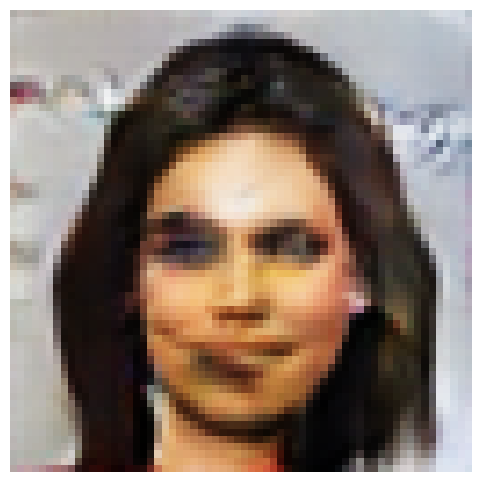

In [16]:
alpha = 0.8
z3   = alpha*z1 + (1-alpha)*z2
with torch.no_grad():
    samples = gen(z3).cpu()*0.5+0.5

grid = torchvision.utils.make_grid(samples, nrow=6)
plt.figure(figsize=(6,6)); plt.axis('off');
plt.imshow(grid.permute(1,2,0));
plt.show()